##掛載雲端硬碟


In [23]:
# from google.colab import drive
# drive.mount('/content/drive')

##更改檔案所在路徑

In [24]:
# Change to your own folder !!!
# %cd /content/drive/MyDrive/Colab\ Notebooks/EAI_Lab4_2023

## Import library

In [25]:
from __future__ import print_function
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from models import vgg

## 設定超參數

In [26]:
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000
EPOCHS = 20
LEARNING_RATE = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
LOG_INTERVAL = 100
CUDA = True
SEED = 1

RESUME = True
START_EPOCH = 0

PRUNE_PATH = './model_prune.pth'
PRUNE_FINETUNE_PATH = './model_prune_finetune.pth'


####檢查是否檢查是否可使用GPU

In [27]:
if(torch.cuda.is_available()):
    CUDA = True
    kwargs = {'num_workers': 1, 'pin_memory': True}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    kwargs = {}


##下載資料集


這裡將訓練集做Augmentation(Pad, RandCrop, Random)，測試集不用做Augmentation

In [28]:
#### DATASET ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

Files already downloaded and verified


## 載入剪枝後的網路與權重

In [29]:
model = None
if(RESUME):
  checkpoint = torch.load(PRUNE_PATH)
  model = vgg(cfg=checkpoint['cfg'])
  model.load_state_dict(checkpoint['state_dict'])

  print('RESUME PRUNE MODEL')

if CUDA:
    model.cuda()

RESUME PRUNE MODEL


##設定Optimizer，這裡使用Stocastic Gradient Descent with

In [30]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

## 定義訓練跟測試函數

In [31]:
#### 訓練函數 #####

train_acc = []
test_acc = []

# 注意: 需自行撰寫儲存每個epoch之train acc的code，以便後續繪製train acc結果圖!
def train(epoch):
    model.train()
    accuracy_per_batch = []
    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('\nTrain Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

        # Store training accuracy of current batch
        pred = output.data.max(1, keepdim=True)[1]
        correct = pred.eq(target.data.view_as(pred)).cpu().sum()
        accuracy = correct / float(len(data))
        accuracy_per_batch.append(accuracy)

    # Store training accuracy of current epoch
    train_acc.append(sum(accuracy_per_batch) / len(accuracy_per_batch))


#### 測試函數 ####
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      for data, target in test_loader:
          if CUDA:
              data, target = data.cuda(), target.cuda()
          data, target = Variable(data), Variable(target)
          output = model(data)
          test_loss += F.cross_entropy(output, target, reduction='sum').data.item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()

      test_loss /= len(test_loader.dataset)
      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      
      # Store testing accuracy of current epoch
      test_acc.append(correct / float(len(test_loader.dataset)))
      
      return correct / float(len(test_loader.dataset))

best_prec1 = 0.
for epoch in range(START_EPOCH, EPOCHS):
    # Learning Rate在0.5EPOCHS與0.75EPOCHS調整為原本之十分之一
    if epoch in [EPOCHS*0.5, EPOCHS*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    train(epoch)
    prec1 = test()

    # 儲存模型權重，方便做後續剪枝,後續訓練
    if(prec1 > best_prec1):
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
        }, PRUNE_FINETUNE_PATH)

    best_prec1 = max(prec1, best_prec1)

print('\n TRAIN PRUNED MODEL DONE!')



Train Epoch: 0 [0/50000 (0.0%)]	Loss: 0.689965

Train Epoch: 0 [10000/50000 (20.0%)]	Loss: 0.670127

Train Epoch: 0 [20000/50000 (40.0%)]	Loss: 0.601255

Train Epoch: 0 [30000/50000 (60.0%)]	Loss: 0.440768

Train Epoch: 0 [40000/50000 (80.0%)]	Loss: 0.239888

Test set: Average loss: 0.4959, Accuracy: 8538/10000 (85.4%)


Train Epoch: 1 [0/50000 (0.0%)]	Loss: 0.410486

Train Epoch: 1 [10000/50000 (20.0%)]	Loss: 0.221855

Train Epoch: 1 [20000/50000 (40.0%)]	Loss: 0.358205

Train Epoch: 1 [30000/50000 (60.0%)]	Loss: 0.266484

Train Epoch: 1 [40000/50000 (80.0%)]	Loss: 0.378187

Test set: Average loss: 0.4373, Accuracy: 8594/10000 (85.9%)


Train Epoch: 2 [0/50000 (0.0%)]	Loss: 0.355073

Train Epoch: 2 [10000/50000 (20.0%)]	Loss: 0.372916

Train Epoch: 2 [20000/50000 (40.0%)]	Loss: 0.301011

Train Epoch: 2 [30000/50000 (60.0%)]	Loss: 0.278351

Train Epoch: 2 [40000/50000 (80.0%)]	Loss: 0.358025

Test set: Average loss: 0.5049, Accuracy: 8502/10000 (85.0%)


Train Epoch: 3 [0/50000 (0.0%)

## 繪製Fine-tuning結果圖


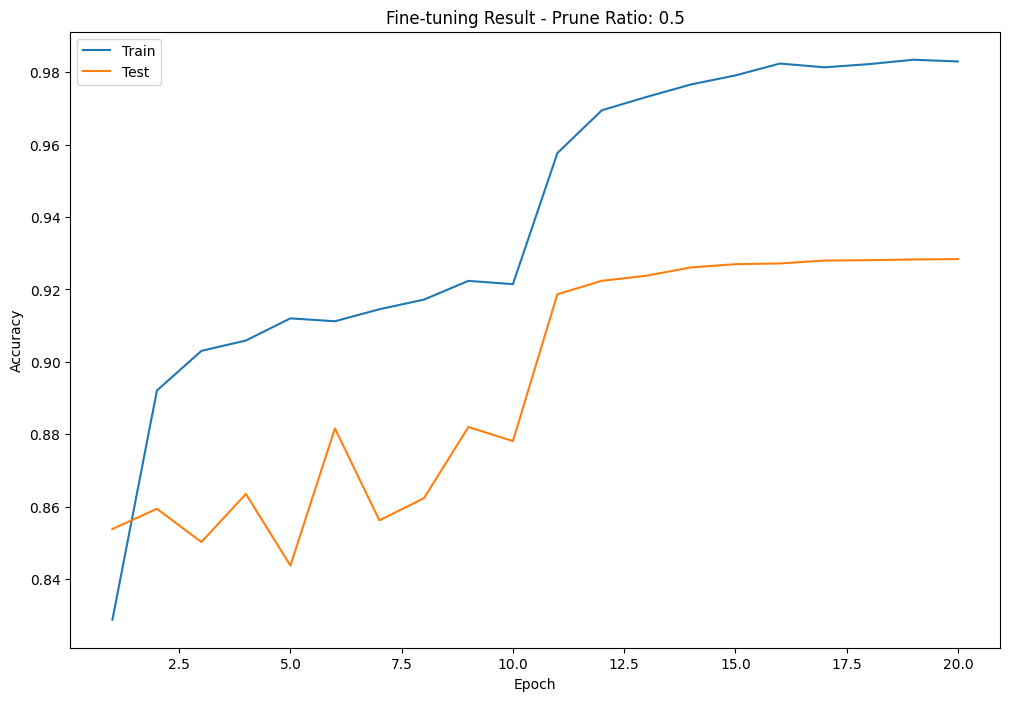

In [32]:
#繪製Fine-tuning結果圖
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, EPOCHS+1), train_acc, label='Train')
plt.plot(np.arange(1, EPOCHS+1), test_acc, label='Test')
plt.title('Fine-tuning Result - Prune Ratio: 0.5')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('prune_finetune_result_05.png')
plt.show()